Time-depth plot the value of the ADCP velocity quality flags. 

In [10]:
import alborexdata
import netCDF4
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import cmocean
import alborexpaths
from alborexpaths import coordinates1, coordinates2

## Quality flag for the whole section
Create colormap with 9 divisions

In [4]:
cmap_error = plt.cm.get_cmap('hot_r', 9)

## Data reading and quality control

In [6]:
adcp = alborexdata.Adcp()
adcp.get_from_netcdf(alborexpaths.adcpfile)
adcp.apply_qc(qf=1)
adcp.get_norm()

/home/ctroupin/Publis/AlborEx-Data-Python/python/alborexdata.py:846: RuntimeWarning: invalid value encountered in sqrt
  self.velnorm = np.sqrt(self.u * self.u + self.v * self.v)


Identify data gaps (no measurements)

In [7]:
deltatime = adcp.time[1:] - adcp.time[:-1]
gaps = np.where(deltatime > 3600)[0]

flagmeaning = ["1: good", "2: probably good", "3: probably bad", "4: bad", "5", "6: spike", 
               "7", "8", "9: missing value"]

Compute ratio of good data over total data.

In [8]:
npoints = adcp.u.shape[0] * adcp.u.shape[1]
for ii in range(1, 10):
    print(str(np.round(len(np.where(adcp.qcu.flatten() == ii)[0]) / npoints * 100, 2)) + '%')

75.14%
0.0%
0.0%
9.9%
0.0%
3.04%
0.0%
0.0%
11.92%


Same but for the first 200 meters

In [9]:
gooddepth = np.where(adcp.depth >= 200.)[0]
adcp.qcu200 = adcp.qcu[:, gooddepth]
npoints = adcp.qcu200.shape[0] * adcp.qcu200.shape[1]
for ii in range(1, 10):
    print(str(np.round(len(np.where(adcp.qcu200.flatten() == ii)[0]) / npoints * 100, 2)) + '%')

57.32%
0.0%
0.0%
16.34%
0.0%
4.7%
0.0%
0.0%
21.64%


## Make the plot

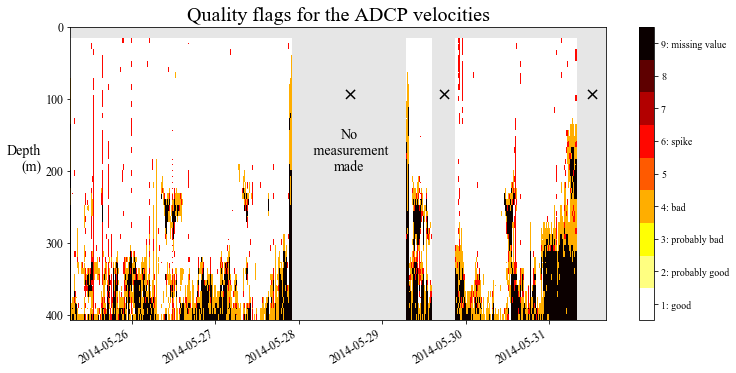

In [11]:
figname = "fig12"
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
ax.set_facecolor(".9")

# Plot separate pcolor to avoid color interpolation during periods 
# without data

imin = 0
for nig, ig in enumerate(gaps):
    imax = ig
    plt.pcolormesh(adcp.dates[imin:imax], adcp.depth, adcp.qcu[imin:imax,:].T, 
                   cmap=cmap_error, vmin=0.5, vmax = 9.5)
    datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[ig+1]), adcp.timeunits)
    if nig < 2:
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    elif nig == 2:
        datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[-1]), adcp.timeunits)
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    imin = imax+1
    
# Add text in no data period
datemean = netCDF4.num2date(0.5 * (adcp.time[gaps[0]] + adcp.time[gaps[0]+1]), adcp.timeunits)
plt.text(datemean, 200, "No\n measurement\nmade", 
         fontsize=14, ha="center")


plt.gca().invert_yaxis()
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar()
cb.set_ticks(range(0, 10))
cb.set_ticklabels(flagmeaning)
plt.yticks(np.arange(0, 401, 100.))
# cb.set_label("QF", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Quality flags for the ADCP velocities", fontsize=20)
plt.xlim(adcp.dates[0], adcp.dates[-1])
fig.autofmt_xdate()
plt.savefig(os.path.join(alborexpaths.figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()